## Exptl analysis
Last ran on colab, 240711

This notebook
* loads tif files from a migration experiment,
* uses trackpy to find moving cells, and
* fits a linear equation to their mean square displacements to obtain a diffusion coefficient.

Data
* My input data is currently located at
/content/drive/MyDrive/public/
which is mounted to google drive.
* These data are publicly available at [link](https://drive.google.com/drive/folders/1lC30mEMIAH-ruUNCrrswfqFnj8l3UBKm?usp=sharing)
* This path will need to be adjusted in the notebook below if data are stored elsewhere

Usage:
* Copy files of interest to an appropriate google drive directory
(current set is from Emily's Feb collections)
* run the first part of the code to completion and **modify the default parameters** to work with your data
* once the right parameters are determined, process your remaining files; a csv file should result for each input file

To analyze
* Use second part of notebook to load in csv files and plot

# Install needed packages



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip3 install pims trackpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84590 sha256=3d7f2abb4eaa374aef3c16b04a13e092fb2152b9c3a47cb0ce261c581ec73c31
  Stored in directory: /root/.cache/pip/wheels/19/dc/d2/e872d34a5e460ff64d2f916938044498fc123855a68318b9d5
  Created wheel for trackpy: filename=trackpy-0.6.4-py3-none-any.whl size=130035 sha256=b79353c59d39582da19f0863236057517e7ab6801475df57ba97e3383ee5a683
  Stored in directory: /root/.cache/pip/wheels/1e/e0/b0/fb454bc84bb6f56fb1017f941718c4a12753515e3350e8179b
Successfully built pims trackpy


Check out cellmigration github repo

In [ ]:
!git clone https://github.com/huskeypm/cellmigration.git
#!cd cellmigration; git pull

Cloning into 'cellmigration'...
remote: Enumerating objects: 926, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 926 (delta 169), reused 147 (delta 119), pack-reused 684 (from 1)
Receiving objects: 100% (926/926), 17.20 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
import sys
sys.path.append("cellmigration")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
import tifffile
import math
import cv2
import os
import expt_analysis.trackcells as tc

pd.set_option('display.max_rows',1000)

# Process raw images
## Image processing

Define inputs (pretty much the only places needed for making changes)

In [ ]:
!ls /content/cellmigration

batchProcess.py		   cont_analysis	  processData.py
brownian_v2.py		   expt_analysis	  processYaml.py
brownian_v3.py		   expt_analysis.ipynb	  README_1.md
brownian_v4.py		   histo.ipynb		  README.md
brownian_v5.py		   lattice.py		  run
brown_util.py		   LICENSE		  states.py
brown_wnonbond.py	   master.ipynb		  TAM_example.ipynb
calculator.py		   migration_paper.ipynb  tests
concentration.py	   paper		  update.py
conda_openmm_pytraj.ipynb  parameters.py	  validation.py
config.bash		   pdb_antiquated.py


In [ ]:
# read in image and show first frame
user = "local"
user = "remote"
if user == "local":
  name='1'
  useGdrive = False
  path="/home/pkh-lab-shared/echo_nfs/microscopy_data/2_28_24_migration/022824"
  fileName = path+"/Position_1_movie.tif".format(name)
    #fileName=r"C:\Users\ekrue\Downloads\12_13_23_{}.tif".format(name)
elif user == "remote":
  name = "1" #
  name = "3"
  gpath=('/content/drive')
  path=gpath+"/MyDrive/public/Migration_Data/brightfield test"
  fileName = path+"/Position_2_test.tif".format(name)
  useGdrive=True
  sourcePath = "/content/cellmigration/"


In [ ]:
path="/home/pkh-lab-shared/echo_nfs/microscopy_data/2_28_24_migration/022824"
fileName = path+"/Position_1_movie.tif".format(name)

### Parameters

In [ ]:
#
#  Parameters to edit
#
# time/frame conversion
fr = 90 # s/fr # experiment


# image processing parameters (disable downsample and crop for full analyses )
downsampleRate = 0
#crop=[[300,900],[300,900]]
crop=[[0,1000],[0,1000]]


thresh=0 # threshold for raw images

# determine parameters to track particles
# paramters: diameter, minmass
#- positiion 1
#iameter=101 # adjust me first
#inmass = 75000
#- positiion 2
#diameter=91  # adjust me first
#minmass = 100
#- positiion 3
#diameter=101  # adjust me first
#minmass = 1000
#cropped position 1 values
diameter=101
minmass=20000000

# for fitting MSDs
fittingRange=[0,200]

PixelSize=1.06 #microns per pixel



## Read images


# New Section

In [ ]:
print(f"Reading {fileName}")

Reading /content/drive/MyDrive/public/Migration_Data/brightfield test/Position_2_test.tif


### Mount google drive.
I added a shortcut to a shared tif file in my 'public' directory

 /content/drive/MyDrive/public/

In [ ]:
if useGdrive:
  from google.colab import drive
  drive.mount(gpath)

Mounted at /content/drive


(25, 2040, 2040)


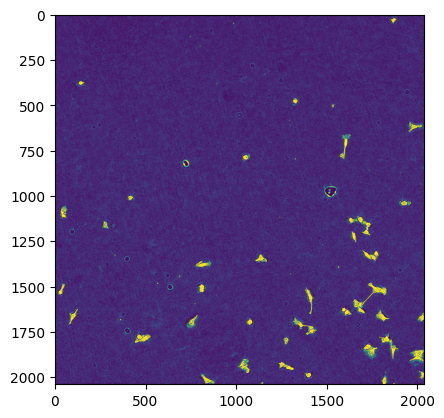

In [ ]:
# read image
raw_data = tifffile.imread(fileName)
print(raw_data.shape)

multiChannel = False
if multiChannel:
  channel== 0
  frames=raw_data[:,channel,:,:]
else:
  frames=raw_data[:,:,:]

plt.imshow(frames[0,:,:])


### Apply threshold to suppress background noise

(25, 1000, 1000)


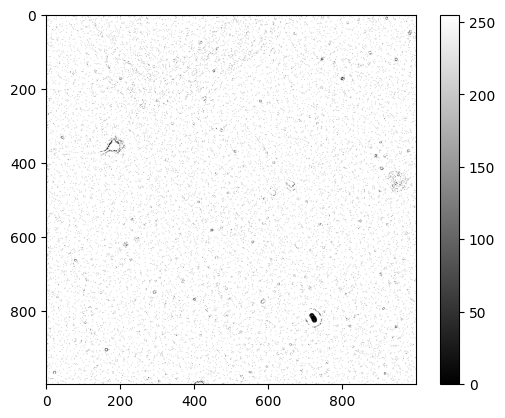

In [ ]:
threshed = tc.ProcessFrames(frames,
                            downsampleRate=downsampleRate,
                            crop=crop,thresh=thresh)
#print(np.min(threshed[0,:]))


### Tracking

* If cells aren't detecting, reduce diameter/minmass or both.
* The displayed mass histogram can help with this optimization

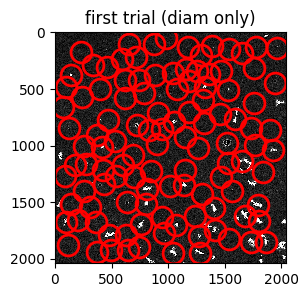

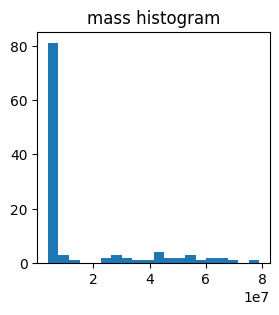

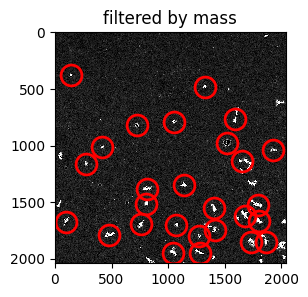

In [ ]:
dummy = tc.TrialParams(frames,refFrame=0,diameter=diameter,minmass=minmass)
if dummy.shape[0] <1:
  print("Error finding cells; try different parameters")
else:
  finalStack = threshed


In [ ]:
# run batch/tracking
fb=tc.DoTracking(frames,diameter=diameter,minmass=minmass)

try:
  print("shape final %d"%fb.shape[0])
except:
  print("Unsuccessful tracking")

# fb is a pandas record of coordinates, mass, signal strength, frame
fb

Frame 24: 25 features
shape final 732


y            x          mass       size       ecc  \
0     381.099817   143.100854  2.611671e+07  12.051283  0.150767   
1     480.207886  1324.182820  2.939617e+07  12.003381  0.042848   
2     767.275593  1589.954606  3.970731e+07  23.461714  0.508158   
3     789.870339  1052.025257  3.512065e+07  12.711844  0.130116   
4     822.537752   721.588984  2.918750e+07  16.692966  0.165921   
5     980.803469  1521.450998  4.209659e+07  31.194755  0.106488   
6    1013.417421   416.150457  2.569146e+07  11.455560  0.052767   
7    1042.234446  1928.598941  4.179715e+07  17.213193  0.367543   
8    1135.291584  1648.418723  4.502232e+07  26.706542  0.384226   
9    1163.639148   278.982821  3.253561e+07  15.618969  0.209228   
10   1349.562103  1136.113517  5.443415e+07  25.630280  0.548063   
11   1380.360553   814.441444  6.240060e+07  23.169736  0.485824   
12   1512.473911   808.545869  4.743324e+07  14.186048  0.234578   
13   1549.060935  1401.758269  5.467119e+07  26.280109  0.569779   
14   1523.947277  1797.083206  6.808362e+07  26.373257  0.388049   
15   1617.665246  1682.179845  5.993856e+07  30.993165  0.547747   
16   1695.990536   758.827903  5.026556e+07  27.819587  0.698841   
17   1667.379603  1800.580271  6.577152e+07  22.188875  0.394041   
18   1697.802492  1073.561531  3.367204e+07  11.598748  0.058959   
19   1671.034038    95.586711  4.842728e+07  28.005829  0.676254   
20   1741.270087  1409.751202  5.607943e+07  19.982019  0.071648   
21   1800.000970  1274.120392  2.883397e+07  12.422254  0.179724   
22   1789.396842   473.375519  6.765280e+07  28.452967  0.452956   
23   1850.228022  1734.622050  7.895361e+07  29.640784  0.222673   
24   1854.359202  1864.708606  4.916666e+07  26.400510  0.694861   
25   1945.963759  1283.899761  4.516641e+07  26.040960  0.575449   
26   1946.114321  1045.620220  6.278783e+07  30.033419  0.525357   
27    381.689586   143.876186  2.618204e+07  11.640248  0.132381   
28    480.214821  1326.800928  2.766080e+07  11.948548  0.025534   
29    618.258700  1970.718246  5.533086e+07  17.681211  0.076765   
30    729.198736  1593.873967  4.764983e+07  27.219617  0.595627   
31    787.317319  1057.490036  3.660147e+07  12.674835  0.104905   
32    822.073766   722.443832  2.998144e+07  16.478328  0.148565   
33    980.696911  1521.863408  4.156763e+07  31.270551  0.135752   
34   1010.757678   416.994215  2.421146e+07  12.365521  0.042227   
35   1044.089430  1926.570508  4.751329e+07  20.379837  0.500584   
36   1095.414626    50.162743  5.973388e+07  28.270251  0.554675   
37   1161.789265   279.169403  3.295434e+07  13.219123  0.241016   
38   1224.467240  1649.411903  3.611681e+07  15.425839  0.467774   
39   1335.195705  1759.875794  6.307329e+07  25.935604  0.336374   
40   1348.061619  1136.769861  5.438738e+07  18.052709  0.027473   
41   1459.595927   789.710807  4.524271e+07  14.614151  0.213588   
42   1515.912950  1767.063948  7.205326e+07  28.932740  0.563710   
43   1640.671134  1606.333435  4.680310e+07  18.495785  0.402017   
44   1671.434611    94.783150  4.530252e+07  18.635506  0.285223   
45   1698.488105   762.094474  4.964760e+07  29.057627  0.673597   
46   1666.123782  1803.192117  5.692114e+07  30.950209  0.563488   
47   1696.658344  1073.390277  3.110973e+07  11.627474  0.133496   
48   1748.158572  1411.480973  3.267253e+07  21.975577  0.349061   
49   1799.911505  1272.865099  2.551789e+07  12.030305  0.207570   
50   1789.591949   475.248883  6.039109e+07  30.979648  0.577923   
51   1848.659414  1737.218338  7.820804e+07  27.748517  0.268300   
52   1859.569271  1865.395146  4.114017e+07  17.425901  0.464136   
53   1935.328424  1255.703266  3.427158e+07  20.902178  0.244472   
54   1936.304311  1049.421325  6.728106e+07  27.090058  0.239050   
55   2009.762952  1811.792937  3.359993e+07  35.810370  0.782874   
56    379.939198   146.205848  2.499738e+07  11.203896  0.154078   
57    616.059257  1956.457801  5.573712e+07  25.373900  0.598438   
58 

Frame 24: 25 trajectories present.


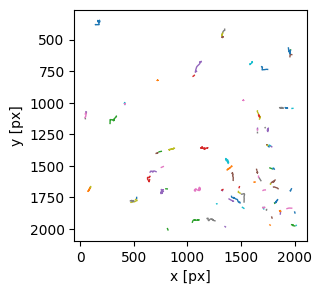

In [ ]:

t = tp.link(fb,30 , memory=0)
#plt.figure()
tp.plot_traj(t);

#print(t)

Before: 172
After: 47


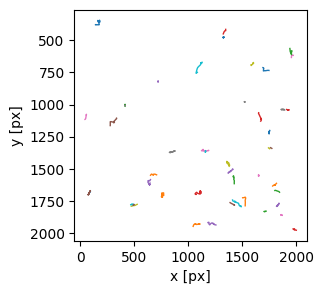

In [ ]:
t1 = tp.filter_stubs(t, 5)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

plt.figure()
tp.plot_traj(t1)
df = t1.copy()

In [ ]:
type(t1)

pandas.core.frame.DataFrame

###Pulls out individual particle trajectories

In [ ]:
def split_by_particle_sorted(df):

  df.index.name = 'frame'
  grouped = df.groupby('particle')
  return dict(map(lambda kv: (int(kv[0]), kv[1][['x', 'y']].sort_index().copy()), grouped))

In [ ]:
df = t1.copy()
plotting = split_by_particle_sorted(df)
print(plotting)

{0:                 x           y
frame                        
0      143.100854  381.099817
1      143.876186  381.689586
2      146.205848  379.939198
3      151.919160  381.151585
4      153.972468  380.359798
5      169.072508  380.992489
6      177.293583  380.143971
7      177.538136  377.811063
8      173.310726  365.538838
9      172.072027  359.045471
10     171.294057  359.154015
11     169.717253  359.008569
12     167.871326  358.442323
13     167.298919  357.113029
14     164.865022  347.193979
15     170.093388  353.952254
16     171.654851  355.258453
17     177.838159  354.473437
18     176.099447  355.088074
19     172.284127  355.709985
20     178.924921  347.751819
21     180.186554  345.485267
22     181.912971  348.832724
23     184.933474  354.860846
24     182.233025  359.162742, 4:                 x            y
frame                         
0      758.827903  1695.990536
1      762.094474  1698.488105
2      754.744726  1708.463948
3      752.211153  1716.165

In [ ]:
def plot_particle_presence(df):
    df.index.name = 'frame'
    grouped = df.sort_index().groupby('particle')

    fig, ax = plt.subplots(figsize=(10, 10))

    for i, (pid, group) in enumerate(grouped):
        #print(f"{pid},{group.index}")
        start_frame = group.index.min()
        end_frame = group.index.max()
        ax.hlines(y=i, xmin=start_frame, xmax=end_frame, color='blue', linewidth=1.5)

    ax.set_yticks(range(len(grouped)))
    ax.set_yticklabels([pid for pid, _ in grouped])
    ax.set_xlabel("Frame")
    ax.set_ylabel("Particle")
    ax.set_title("Particle Presence Over Time (Frames)")
    plt.tight_layout()
    plt.show()

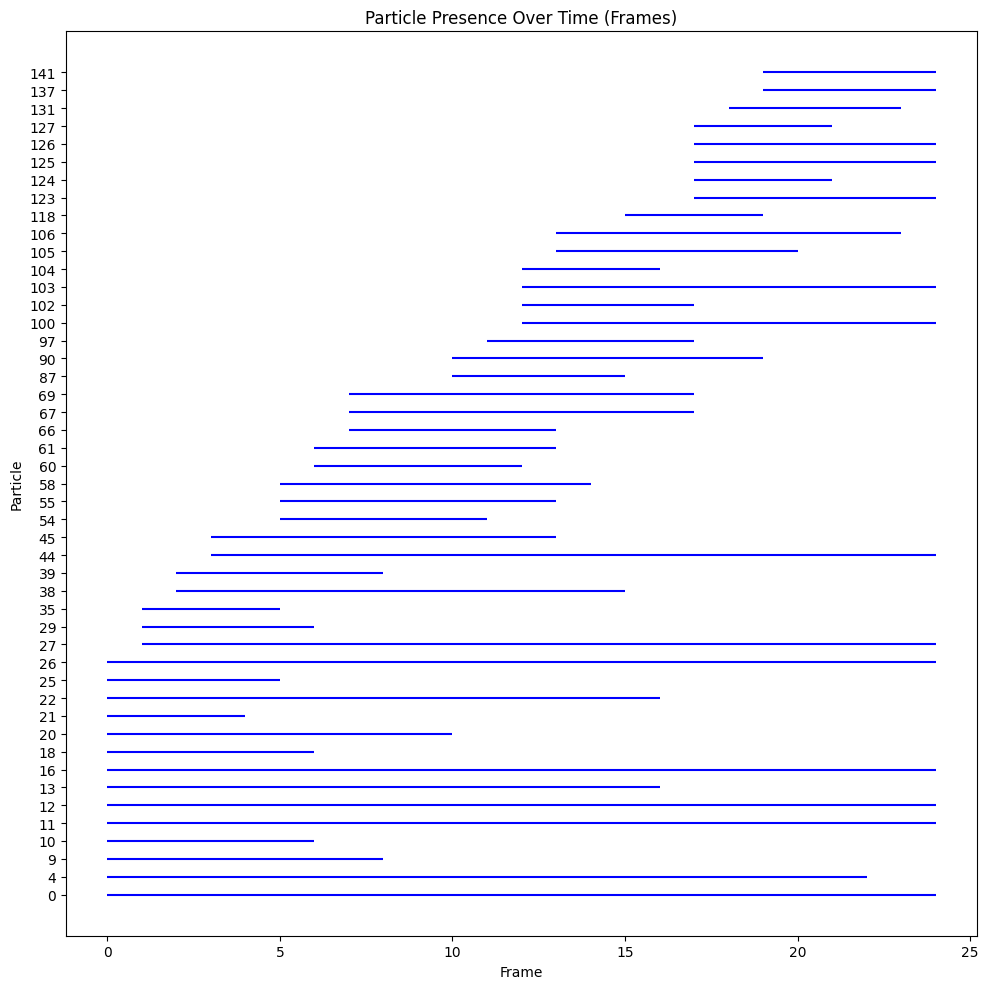

In [ ]:
df = t1.copy()
plot_particle_presence(df)

In [ ]:
def compute_start_end_vectors(particle_dfs):

    summary = {}
    for pid, df in particle_dfs.items():
        if len(df) < 2:
            continue

        x0, y0 = df.iloc[0][['x', 'y']]
        x1, y1 = df.iloc[-1][['x', 'y']]
        dx = x1 - x0
        dy = y1 - y0
        mag = np.sqrt(dx**2 + dy**2)


        summary[pid] = {
            'start': (x0, y0),
            'end': (x1, y1),
            'dx': dx,
            'dy': dy,
            'magnitude': mag,
            'trajectory': df
        }

    return summary

In [ ]:
def Particle_Average_Velocity(particle_dfs2):
  Particle_IDs = list(particle_dfs2.keys())
  packaged_displacement_data = dict()
  packaged_velocity_data = dict()
  AVG_VELs = []

  for Particles in list(range(len(particle_dfs2.keys()))):
    dframe_change = []
    individual_magnitude_stacked = []
    velocity = []


    for frame_IDs in list(range(len(particle_dfs2[Particle_IDs[Particles]]))):
      x0, y0 = particle_dfs2[Particle_IDs[Particles]].iloc[frame_IDs-1][['x', 'y']]
      x1, y1 = particle_dfs2[Particle_IDs[Particles]].iloc[frame_IDs][['x', 'y']]
      dframe_end = int(particle_dfs2[Particle_IDs[Particles]].index[frame_IDs])
      dframe_start = int(particle_dfs2[Particle_IDs[Particles]].index[frame_IDs-1])
      dframe = (dframe_end - dframe_start)*fr*((1/60)*(1/60)) #Length of time between frames and converted to hours
      dframe_change.append(dframe)
      dx = x1 - x0
      dy = y1 - y0
      indiv_magnitude = np.sqrt(dx**2 + dy**2)*PixelSize
      individual_magnitude_stacked.append(indiv_magnitude)
      vel = indiv_magnitude/dframe
      velocity.append(vel)
      velocity_stack = pd.DataFrame(velocity, columns = ["Velocity(um/hr)"])
      time_stack = pd.DataFrame(dframe_change,columns = ["Time(hr)"])
      distance_stack = pd.DataFrame(individual_magnitude_stacked, columns = ["Distance(um)"])
    AVG_VEL = velocity_stack.mean(axis = 0)
    #print(AVG_VEL)
    AVG_VELs.append(float(AVG_VEL.iloc[0]))
    merged = pd.concat([time_stack,distance_stack,velocity_stack], axis = 1)
    merged_corrected = merged.truncate(before=1, axis=0)
    packaged_displacement_data[f"{Particle_IDs[Particles]}"] = merged_corrected

  AVG_VEL_stack = pd.DataFrame(AVG_VELs, columns = ["Average_Velocity(um/hr)"], index = Particle_IDs)
  AVG_VEL_stack.index.name = 'Particle'

  return packaged_displacement_data, AVG_VEL_stack

In [ ]:
def plot_particle_displacements_Velocity_subplots(displacements, AVG_VEL_stack, cols=5, show_ids=True):

  num_particles =len(displacements.keys())
  rows = math.ceil(num_particles / cols)
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), squeeze=False)
  axes = axes.flatten()
  cmap = plt.colormaps.get_cmap('CMRmap')


  Particle_IDs = list(displacements.keys())
  Frame_data = displacements.values()
  for Particles in list(range(len(displacements.keys()))):
    ax = axes[Particles]
    ax.set_title(f"Particle {Particle_IDs[Particles]}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.axis("equal")
    ax.grid(True)

    traj = displacements[Particle_IDs[Particles]]['trajectory']
    x0, y0 = displacements[Particle_IDs[Particles]]['start']
    dx, dy = displacements[Particle_IDs[Particles]]['dx'], displacements[Particle_IDs[Particles]]['dy']


    ax.plot(traj['x'], traj['y'], 'o-', color=cmap(10), alpha=0.6, label='Trajectory')
    ax.arrow(x0, y0, dx, dy,
               head_width=0.09*(np.sqrt(dx**2 + dy**2)), head_length=0.1*(np.sqrt(dx**2 + dy**2)), fc=cmap(50), ec=cmap(50),
               length_includes_head=True, linewidth=2, label='Net Displacement')

    if show_ids:
        ax.text(x0 + dx * 0.5, y0 + dy * 0.5,
                f"P_ID:{Particle_IDs[Particles]}\n Displacement:{displacements[Particle_IDs[Particles]]['magnitude']:.2f}\n Velocity:{AVG_VEL_stack['Average_Velocity(um/hr)'][Particle_IDs[Particles]]:.2f}",
                fontsize=8, color=cmap(100), ha='center')

    ax.legend(fontsize=7)

  plt.tight_layout()
  plt.suptitle("Individual Particle Trajectories and Displacements", fontsize=16, y=1.02)
  plt.show()

In [ ]:
df = t1.copy()



<Axes: ylabel='Frequency'>

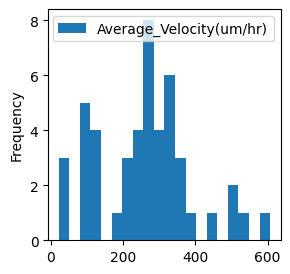

In [ ]:
df = t1.copy()
particle_dfs2 = split_by_particle_sorted(df)
displacements = compute_start_end_vectors(particle_dfs2)
AVE = Particle_Average_Velocity(particle_dfs2)
AVE[1].plot.hist(bins = 20)


In [ ]:
print(AVE[1]["Average_Velocity(um/hr)"][3]) #If the velocity of a specific particle is desired, input particle number of interest here

93.08748071312687


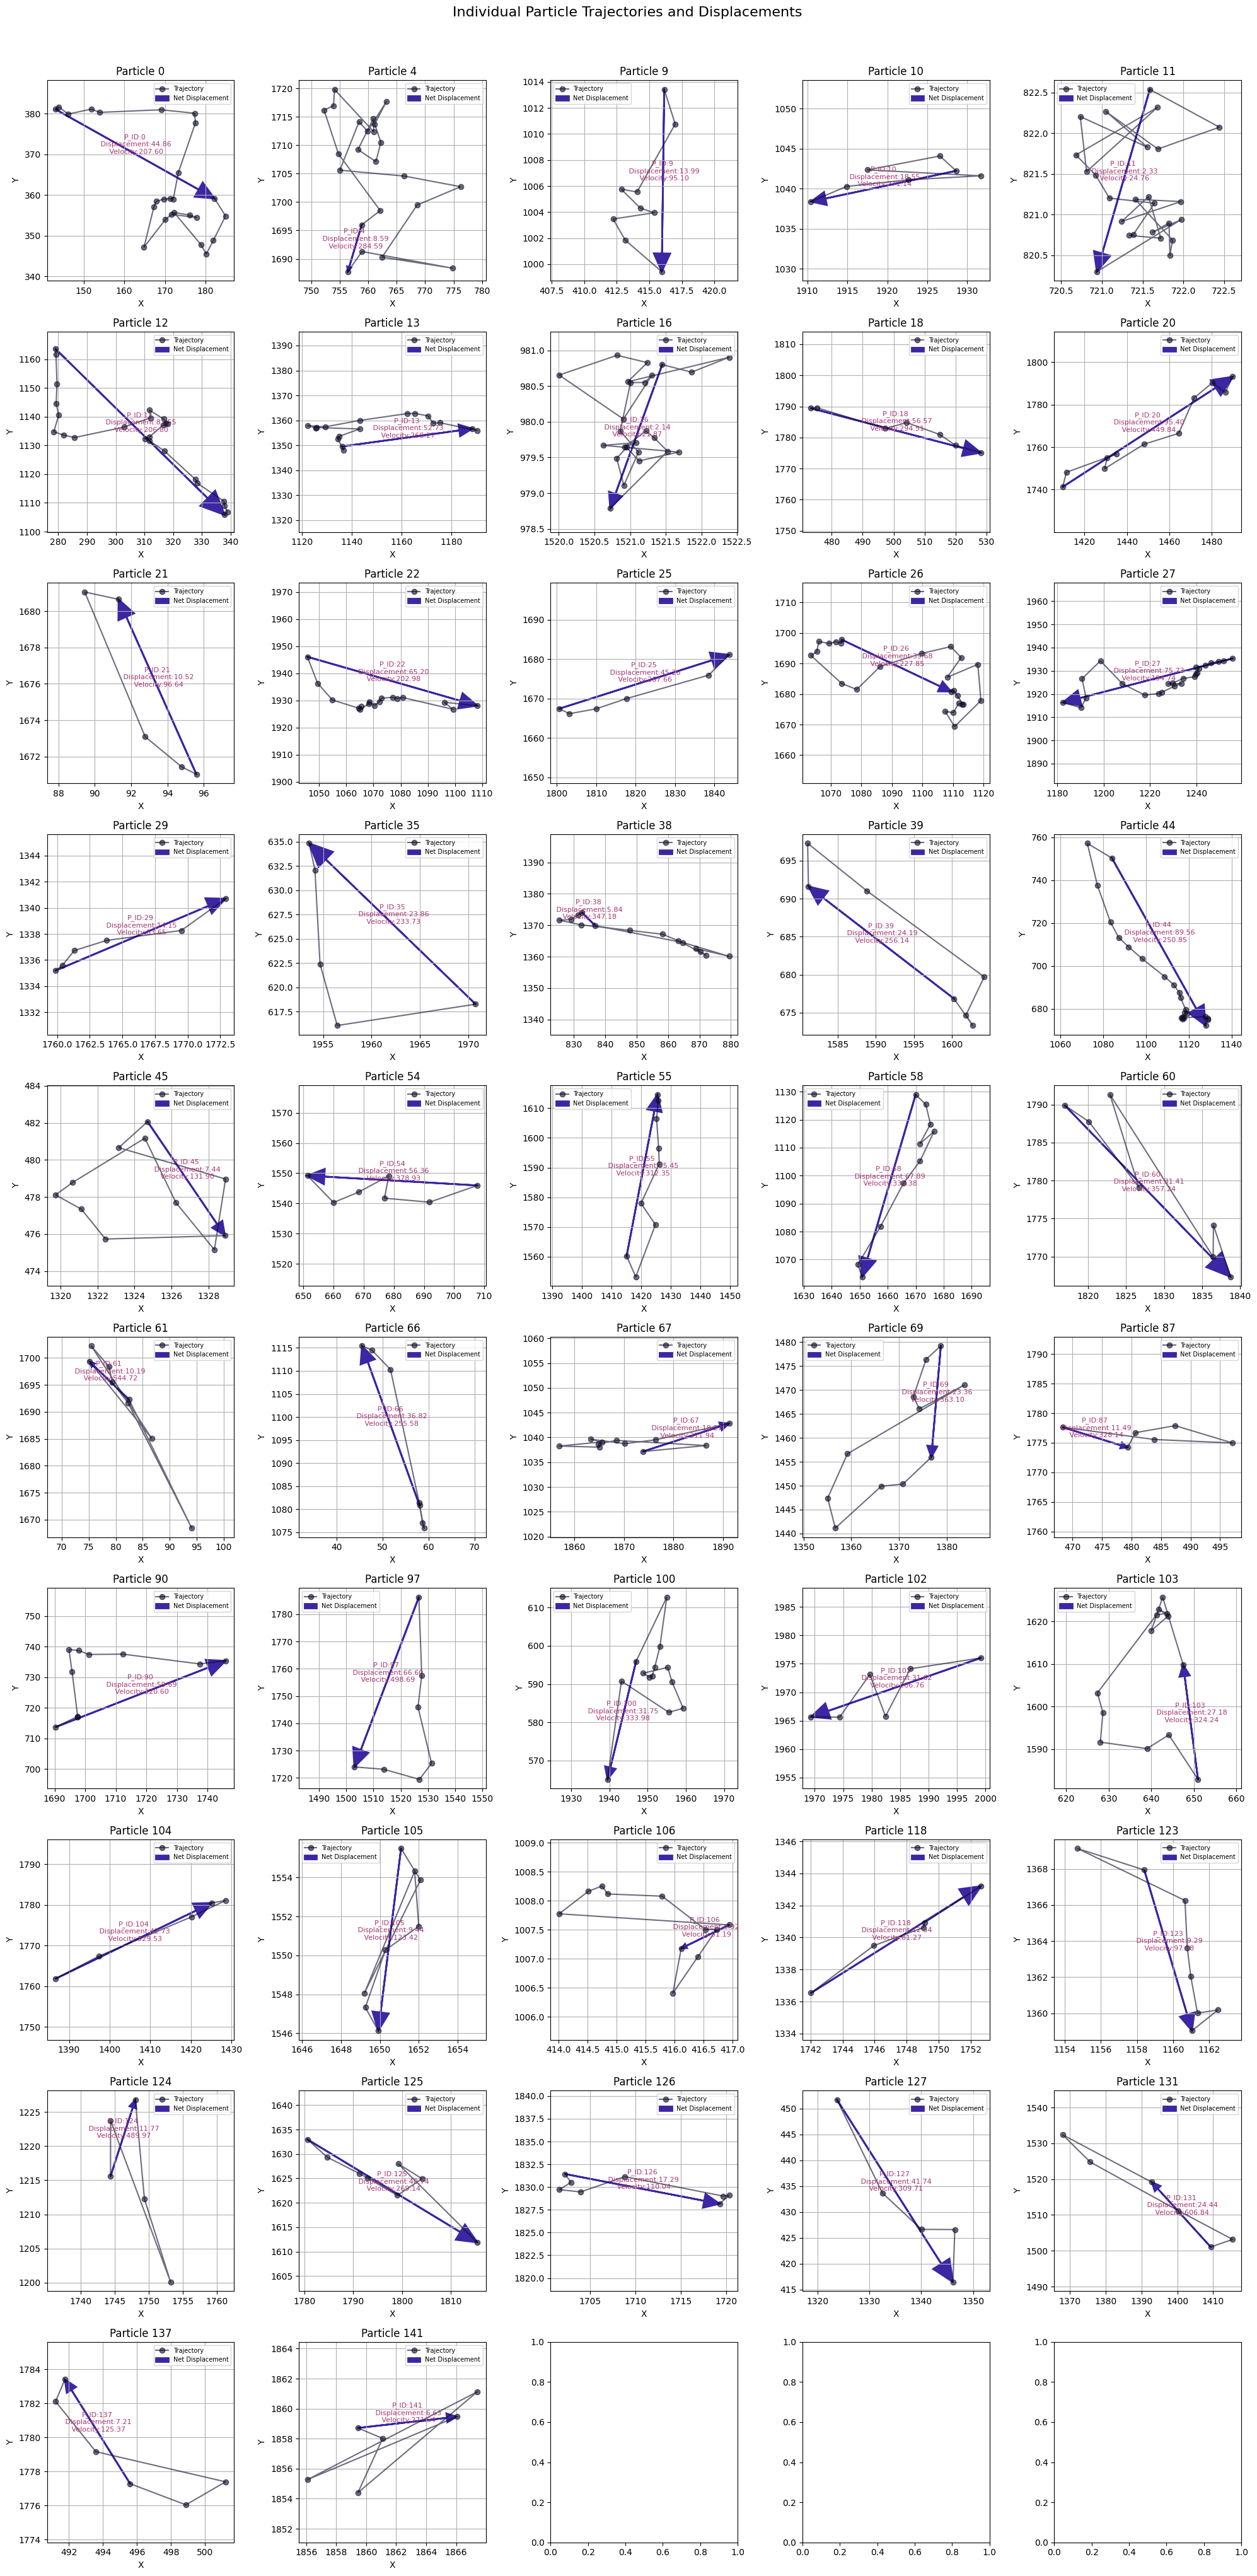

In [ ]:
plot_particle_displacements_Velocity_subplots(displacements, AVG_VEL_stack = AVE[1], cols=5, show_ids=True)

###Uses the trajectories to determine magnitude and angle of the directional vectors  

In [ ]:
def compute_normalized_displacement_vectors(particle_dfs):
    """
    For each particle, compute the direction (angle) and normalized magnitude
    of the net displacement vector.
    """
    summary = []
    for pid, df in particle_dfs.items():
        if len(df) < 2:
            continue
        x0, y0 = df.iloc[0][['x', 'y']]
        x1, y1 = df.iloc[-1][['x', 'y']]
        dx = x1 - x0
        dy = y1 - y0
        magnitude = np.sqrt(dx**2 + dy**2)

        if magnitude == 0:
            continue  # skip zero-motion particles

        unit_dx = dx / magnitude
        unit_dy = dy / magnitude
        angle = np.arctan2(dy, dx)  # radians
        summary.append({
            'particle': pid,
            'angle': angle,
            'magnitude': magnitude,
            'unit_dx': unit_dx,
            'unit_dy': unit_dy
        })

    # Normalize magnitudes
    max_mag = max(p['magnitude'] for p in summary)
    for p in summary:
        p['normalized_mag'] = p['magnitude'] / max_mag if max_mag > 0 else 0

    return summary

In [ ]:
def sort_norms_by_length(displacements):
  short_norms = []
  medium_norms = []
  long_norms = []
  for i, p in enumerate(displacements):
    if p['normalized_mag'] > 0.67:
      long_norms.append({'particle' : i,
                         'angle' : p['angle'],
                         'normalized_mag': p['normalized_mag']
                         })
    elif 0.66 > p['normalized_mag'] > 0.34:
      medium_norms.append({'particle' : i,
                         'angle' : p['angle'],
                         'normalized_mag': p['normalized_mag']
                           })
    elif 0.33 > p['normalized_mag']:
      short_norms.append({'particle' : i,
                         'angle' : p['angle'],
                         'normalized_mag': p['normalized_mag']
                           })
  return short_norms, medium_norms, long_norms

In [ ]:
def plot_radial_displacement(summary):
    """
    Plots a radial (polar) plot where each particle’s net displacement vector
    is shown as an arrow from the origin, scaled by normalized magnitude.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    rmax = max(p['normalized_mag'] for p in summary)



    for p in summary:
        angle = p['angle']
        r = p['normalized_mag']
        ax.arrow(angle, 0, 0, r,
                 head_width=0.05, head_length=0.01,
                 length_includes_head=True,
                 color='tab:blue', alpha=0.8)

    ax.set_title("Radial Plot of Particle Displacements\n(Angle = Direction, Length = Normalized Magnitude)", va='bottom',pad = 20)
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(1)
    ax.set_rlim(0, rmax)
    plt.show()

In [ ]:
def left_versus_right_counter(summary):
    pi = math.pi
    left_count = 0
    right_count = 0
    for p in summary:
      if ((pi/2) > p['angle'] > (-pi/2)):
        left_count += 1
      else:
        right_count += 1
    return left_count, right_count

In [ ]:
print(len(summary[1]))

31


26


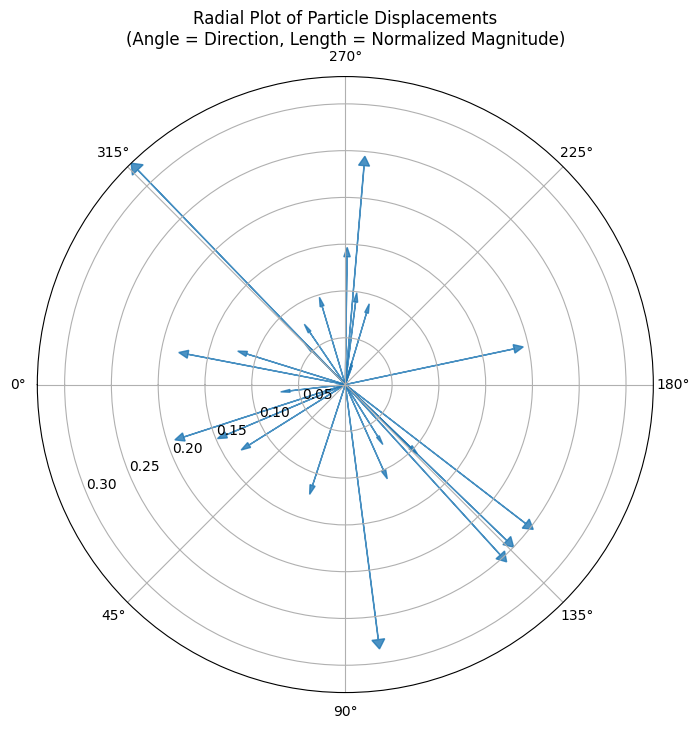

left_moving cells in this range: 11
right_moving cells in this range: 15
Number of particles within this range: 26


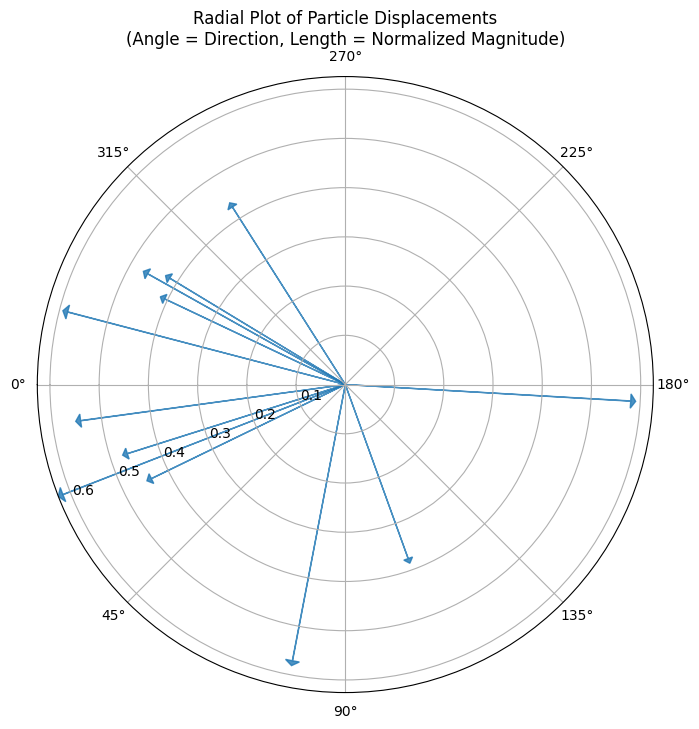

left_moving cells in this range: 10
right_moving cells in this range: 2
Number of particles within this range: 12


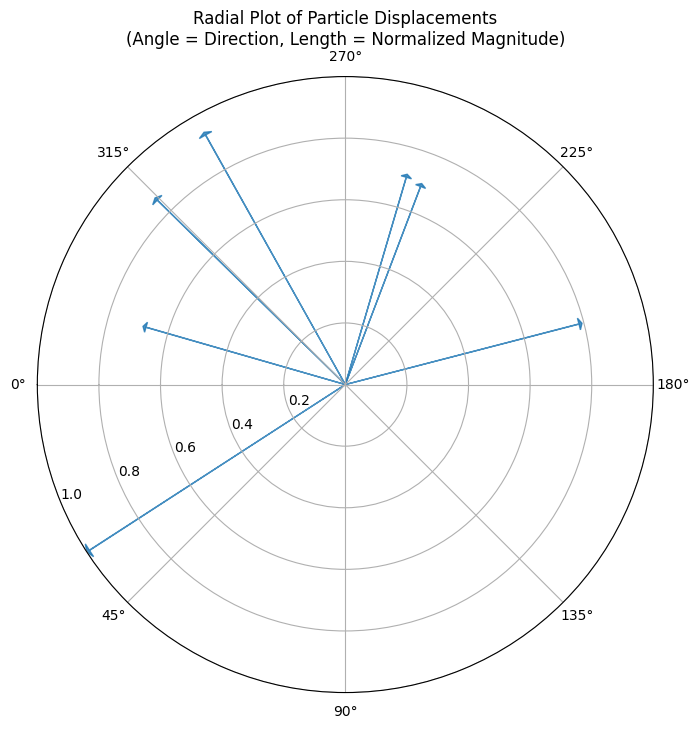

left_moving cells in this range: 4
right_moving cells in this range: 3
Number of particles within this range: 7


In [ ]:
df = t1.copy()
particle_dfs = split_by_particle_sorted(df)
displacements = compute_normalized_displacement_vectors(particle_dfs)
summary = sort_norms_by_length(displacements)
print(len(summary[0]))


plot_radial_displacement(summary[0]) #summary[0] = short_norms
left_moving = left_versus_right_counter(summary[0])[0]
print('left_moving cells in this range:' , left_moving)
right_moving = left_versus_right_counter(summary[0])[1]
print('right_moving cells in this range:' , right_moving)
print('Number of particles within this range:' , right_moving+left_moving)


plot_radial_displacement(summary[1]) #summary[1] = medium_norms
left_moving = left_versus_right_counter(summary[1])[0]
print('left_moving cells in this range:' , left_moving)
right_moving = left_versus_right_counter(summary[1])[1]
print('right_moving cells in this range:' , right_moving)
print('Number of particles within this range:' , right_moving+left_moving)


plot_radial_displacement(summary[2]) #summary[2] = long_norms
left_moving = left_versus_right_counter(summary[2])[0]
print('left_moving cells in this range:' , left_moving)
right_moving = left_versus_right_counter(summary[2])[1]
print('right_moving cells in this range:' , right_moving)
print('Number of particles within this range:' , right_moving+left_moving)

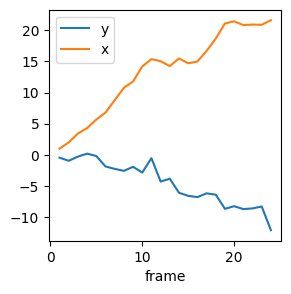

               y          x
frame                      
1      -0.454582   1.000620
2      -0.949760   2.001821
3      -0.276646   3.419317
4       0.195917   4.300506
5      -0.188419   5.666322
6      -1.863115   6.784982
7      -2.249299   8.772281
8      -2.567895  10.762165
9      -1.917145  11.774328
10     -2.840067  14.183157
11     -0.528960  15.368112
12     -4.284009  15.030160
13     -3.838243  14.256891
14     -6.090981  15.478969
15     -6.579786  14.700515
16     -6.785145  14.977764
17     -6.175823  16.681716
18     -6.397096  18.654641
19     -8.664442  21.092735
20     -8.238423  21.432488
21     -8.708044  20.835208
22     -8.596979  20.911490
23     -8.289355  20.881215
24    -12.097965  21.612140


In [ ]:
d = tp.compute_drift(t1)
d.plot()
plt.show()
print(d)

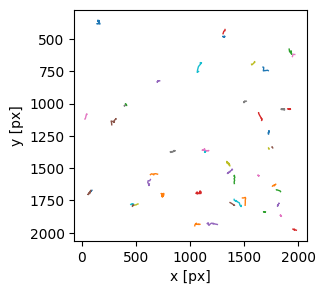

                          y            x          mass       size       ecc  \
frame particle                                                                
0     0          381.099817   143.100854  2.611671e+07  12.051283  0.150767   
      4         1695.990536   758.827903  5.026556e+07  27.819587  0.698841   
      9         1013.417421   416.150457  2.569146e+07  11.455560  0.052767   
      10        1042.234446  1928.598941  4.179715e+07  17.213193  0.367543   
      11         822.537752   721.588984  2.918750e+07  16.692966  0.165921   
      12        1163.639148   278.982821  3.253561e+07  15.618969  0.209228   
      13        1349.562103  1136.113517  5.443415e+07  25.630280  0.548063   
      16         980.803469  1521.450998  4.209659e+07  31.194755  0.106488   
      18        1789.396842   473.375519  6.765280e+07  28.452967  0.452956   
      20        1741.270087  1409.751202  5.607943e+07  19.982019  0.071648   
      21        1671.034038    95.586711  4.842728e+

In [ ]:
tm = tp.subtract_drift(t1.copy(), d)
plt.figure()
tp.plot_traj(tm);
plt.show()
print(tm)

In [ ]:
    # compute ensemble msd
em1 = tp.emsd(tm, PixelSize, 1/fr, max_lagtime = 480)
em2 = tp.emsd(t1, PixelSize, 1/fr, max_lagtime = 480)

    # reformat MSD data
time1 = []
for i in em1.index:
  time1.append(i)
data = []
for i in em1.values:
  data.append(i)
firstCell = np.array( data )

print(em1)

lagt
90.0        87.782455
180.0      206.201310
270.0      344.937656
360.0      499.476682
450.0      639.224668
540.0      817.706490
630.0      809.574095
720.0      966.328554
810.0     1031.178425
900.0      940.564267
990.0      863.360204
1080.0     887.624446
1170.0     987.612420
1260.0    1222.182927
1350.0    1390.589496
1440.0    1585.667886
1530.0    1693.349840
1620.0    1934.286001
1710.0    2192.209277
1800.0    2415.001570
1890.0    2439.036549
1980.0    2172.219114
2070.0    2654.861802
2160.0    1192.497173
Name: msd, dtype: float64


<ipython-input-34-10a8e8dda58d>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(em1.index, em1, 'k', color=cmap(100), label = 'MSD drift corrected')
<ipython-input-34-10a8e8dda58d>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(em2.index, em2, 'k', color=cmap(1), label = 'MSD non-drift corrected')


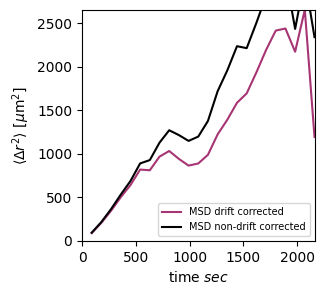

In [ ]:
fig, ax = plt.subplots()
cmap = plt.colormaps.get_cmap('CMRmap')
ax.plot(em1.index, em1, 'k', color=cmap(100), label = 'MSD drift corrected')
ax.plot(em2.index, em2, 'k', color=cmap(1), label = 'MSD non-drift corrected')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='time $sec$')
ax.set(xlim=(0, max(em1.index)));
ax.set(ylim=(0, max(em1)));
ax.legend(fontsize=7)

### MSD analyses
- Based on the cell trajectories identified above

<font color=red>WARNING: the msd plot needs to be rescaled according to correct spatial and temporal units</font>

Frame 24: 25 trajectories present.
Found 732 
Retained 443 particles
Drift 
                y          x
frame                      
1      -0.595957   1.180834
2      -0.546431   2.100912
3      -0.155138   1.827264
4      -0.141116   1.585735
5      -1.364521   2.819851
6      -3.500304   5.786270
7      -5.681102   9.161896
8      -6.277659  11.696357
9      -6.588049  12.952143
10     -8.020541  16.012854
11     -7.709070  17.451043
12    -12.283901  16.573251
13    -12.265492  16.338741
14    -14.471556  17.044761
15    -15.594776  16.019638
16    -15.394698  16.783828
17    -14.752254  18.885115
18    -14.471077  20.909416
19    -15.339427  22.180661
20    -16.271545  22.104009
21    -17.985691  22.935678
22    -19.170253  23.684487
23    -17.754254  22.906801
24    -22.776526  22.916233


<Figure size 500x300 with 0 Axes>

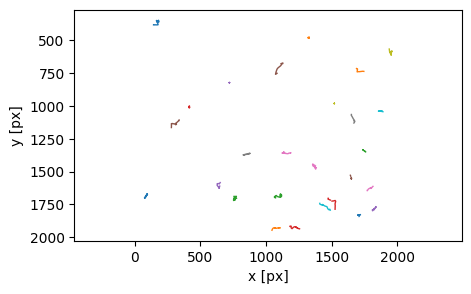

Double check, data contains ALL particle trajectories? (%d)


<Figure size 500x300 with 0 Axes>

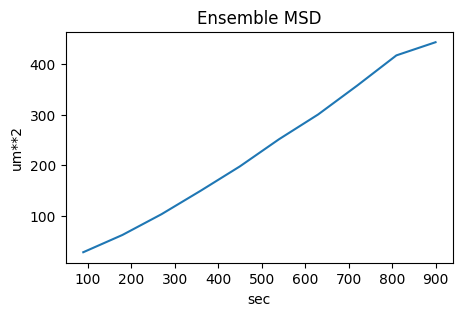

In [ ]:
# compute MSD
ts,traj,msd,im,em=tc.DoMSD(
    fb,
    maxDist=30, # maximum displacement between frames in pixel
    maxMissFrame=2, # allowed number of frames a particle can disappear
    minFrame=10, # minimum number of frames a trajectory needs to last
    pixelSize=0.65, # image pixel size in micron/pixel, specific for each scope and lens (Cytiva 10X: 0.65) and (Spinning Disk: 1.1 at 10X)
    frameRate=1/fr, # image acquisition rate in frames/sec
    max_lagtime=10, # intervals of frames out to which MSD is computed
    name=name
)

### Optional plot
- shows how tracked cells moved

!!!! Need to debug slightly, since incorrect image is being loaded

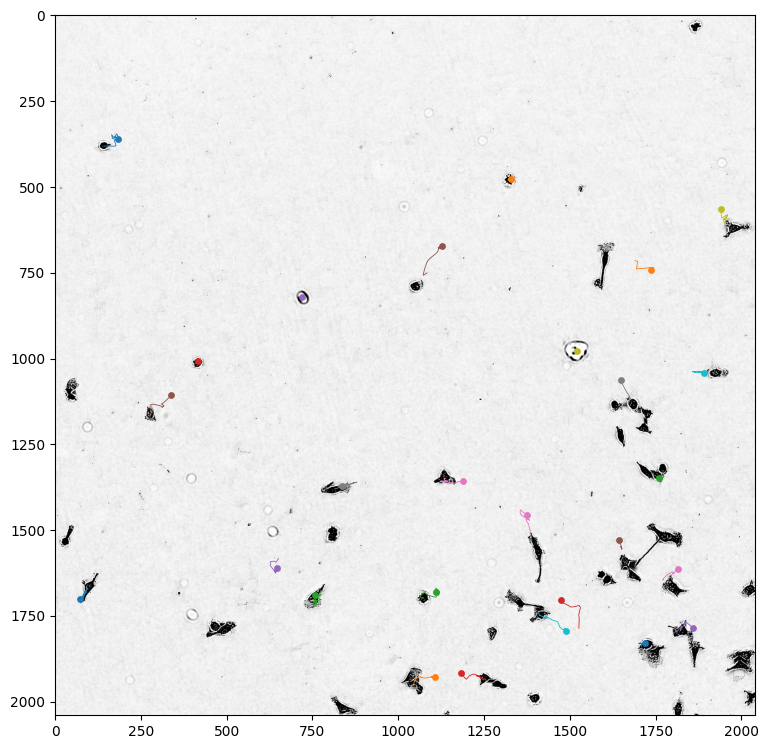

In [ ]:
showTraj=True
if showTraj:
  fig=plt.figure(figsize=(20,20))
  ax=fig.add_subplot(222)
  ax.imshow(frames[0,:,:],cmap='Greys')

  for j in traj['particle'].unique():
      xs=traj[traj['particle']==j]['x'].tolist()
      ys=traj[traj['particle']==j]['y'].tolist()

      # remove ones at the edge
     # if xs[-1]-xs[0]<0:
          #continue

      nFrames=len(xs)
      cs=np.linspace(0,1,nFrames)
      ax.plot(xs,ys,lw=0.6)
      plt.scatter(xs[-1],ys[-1],s=15)

slope/intercept [  0.53970089 -36.26398236]


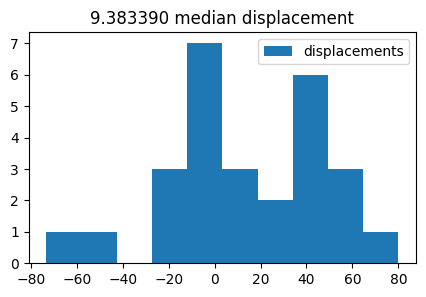

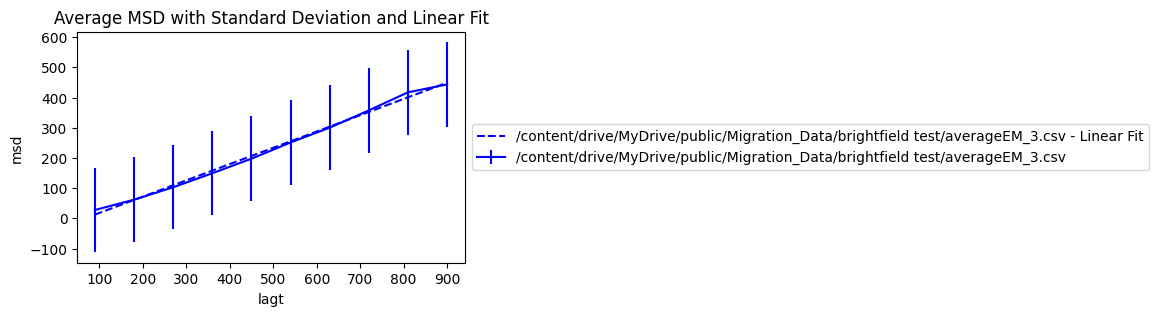

In [ ]:

# get displacements
dists, xdists = tc.CalcDistances(traj) # performed on trajectories BEFORE drift-correction
med = np.median(xdists)
plt.figure()
plt.title("%f median displacement"%med)
plt.hist(xdists,label="displacements")
plt.legend(loc=0)

# save average MSD for each run to csv file
msdFileName=path+'/averageEM_{}.csv'.format(name)
diffFileName=path+'/diff_{}.csv'.format(name)
if name is not None:
    em.to_csv(msdFileName)
    np.savetxt(diffFileName,np.array(xdists))
    # prompt: save pandas dataframe
    traj.to_csv(path+'/traj_{}.csv'.format(name))
    fb.to_csv(path+'/fbframe_{}.csv'.format(name))

msdFile={
    path+'/averageEM_{}.csv'.format(name):{"color":"blue"}
}
plt.figure()
tc.doMSDFit(msdFile, fittingRange=fittingRange)

#individual MSDs? save figures?

### Count left moving/right moving cells
- I believe Xuan implemented this, but I haven't validated it myself

In [ ]:
segInterval=15
nSeg=int(frames.shape[0]/segInterval)

trajs=[]
for seg in range(nSeg):
    ar_tmp=threshed[seg*segInterval:(seg+1)*segInterval,:,:].copy()
    minFrame=segInterval
    f = tp.batch(ar_tmp, diameter, minmass=minmass)
    t_before = tp.link(f, 20, memory=10)
    traj = tp.filter_stubs(t_before, segInterval)
    trajs.append(traj)

Frame 2: 24 features


Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/trackpy/feature.py", line 444, in locate
    black_level, noise = measure_noise(image,

KeyboardInterrupt: 

IndexError: list index out of range

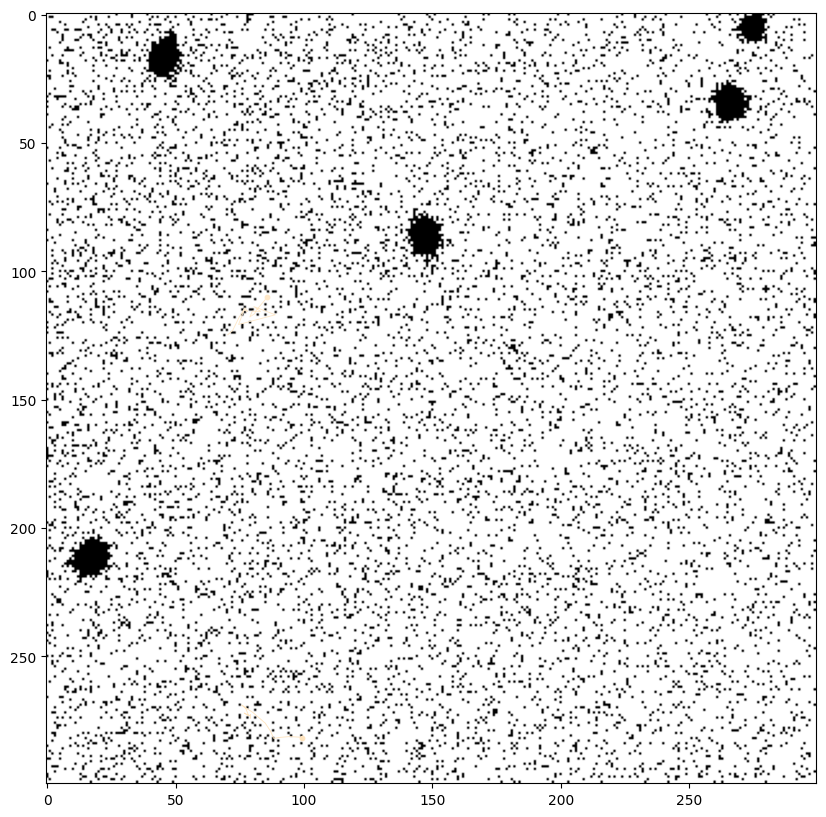

In [ ]:
import matplotlib
cmap1=matplotlib.colormaps['GnBu'] # left-shifting
cmap2=matplotlib.colormaps['OrRd'] # right-shifting
gradient=np.linspace(0.1,1,nSeg)
counts1=0
counts2=0

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.imshow(threshed[0,:,:],cmap='Greys')

for seg in range(nSeg):
    traj=trajs[seg]

    for j in traj['particle'].unique():
        xs=traj[traj['particle']==j]['x'].tolist()
        ys=traj[traj['particle']==j]['y'].tolist()

        if np.abs(xs[-1]-xs[0])<2:
            continue

        nFrames=len(xs)
        cs=np.linspace(0,1,nFrames)

        if xs[-1]<xs[0]:
            cmap=cmap1
            if seg < nSeg/3:
                counts1+=1
        else:
            cmap=cmap2
            if seg < nSeg/3:
                counts2+=1

        plt.plot(xs,ys,c=cmap(gradient[seg]),lw=0.6)
        plt.scatter(xs[-1],ys[-1],color=cmap(gradient[seg]),s=10)

print('Left-shifting:', counts1, ' Right-shifting:', counts2)

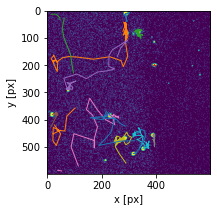

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [ ]:
plt.figure()
plt.imshow(threshed[0,:,:])
tp.plot_traj(traj)

# Post processing
- This should be treated as skeleton code, as the processing of results still needs to be retooled



Create list of names

In [ ]:
path

'/home/ekrueger2/microscopy_data/022824'

slope/intercept [  2.13669037 638.39398653]


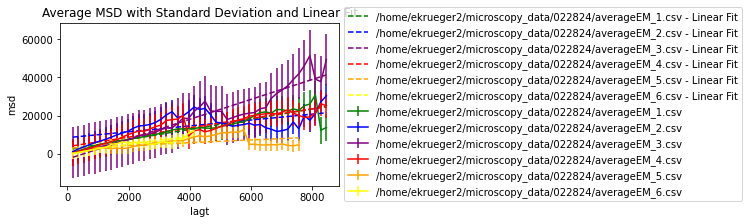

In [ ]:
# import average MSD csv files and plot with Std and linear fit

average_MSD_files={
    'averageEM_Position1.csv':{"color": "blue"},
    'averageEM_Position2.csv':{"color": "purple"},
    'averageEM_Position3.csv':{"color": "red"},
    'averageEM_Position4.csv':{"color": "orange"},
    'averageEM_Position5.csv':{"color": "yellow"},
    'averageEM_Position6.csv':{"color": "green"}
    }
average_MSD_files={
    path+'/averageEM_1.csv':{"color": "green"},
    path+'/averageEM_2.csv':{"color": "blue"},
    path+'/averageEM_3.csv':{"color": "purple"},
    path+'/averageEM_4.csv':{"color": "red"},
    path+'/averageEM_5.csv':{"color": "orange"},
    path+'/averageEM_6.csv':{"color": "yellow"},
}


fittingRange=[0,100]
tc.doMSDFit(average_MSD_files, fittingRange=fittingRange)



<font color=red>NEED TO EDIT ONCE I HAVE THE low/high ATP JOBS </font>


### No ATP

Not sure how this naming scheme was decided upon

In [ ]:
# former path
filenames_confinement = []
filenames_confinement.append(
    path+'/averageEM_Position_1.csv'
    )
diff_filenames = []
diff_filenames.append(
    path+'/diff_Position_1.csv'
    )
caseNames = ["-ATP" for x in range(len(filenames_confinement))]


### With ATP

In [ ]:
# with atp?
filenames_confinement_ATP = []
filenames_confinement_ATP.append(
    path+'/averageEM_Position_2.csv'
    )
diff_filenames_ATP = []
diff_filenames_ATP.append(
    path+'/diff_Position_2.csv'
    )

caseNamesATP = ["+ATP" for x in range(len(filenames_confinement_ATP))]
#print(casesATP)

In [ ]:
filenames_confinement =  filenames_confinement + filenames_confinement_ATP
diff_filenames =  diff_filenames + diff_filenames_ATP
caseNames = caseNames + caseNamesATP

In [ ]:
print(filenames_confinement)

['/content/drive/MyDrive/public//averageEM_Position_1.csv', '/content/drive/MyDrive/public//averageEM_Position_2.csv']


### Load data
We used to load/process images here, but now we just use postprocessed data here (tracking happens elsewhere in notebook)

In [ ]:
cases = dict()
class empty:pass

In [ ]:
for i,filename in enumerate(filenames_confinement):

    # store data
    case = empty()

    #
    case.name = filenames_confinement[i]
    ar = pd.read_csv(filenames_confinement[i])
    print("Lag time isn't quite what we want")
    case.time1 = ar['lagt']
    case.dataavg1 = ar['msd']
    print("D is needed")
    ar = pd.read_csv(filename)
#    case.D = D
    ar = pd.read_csv(diff_filenames[i])
    case.dists = ar

    cases[caseNames[i]] = case


Lag time isn't quite what we want
D is needed
Lag time isn't quite what we want
D is needed


Text(0, 0.5, 'Prob')

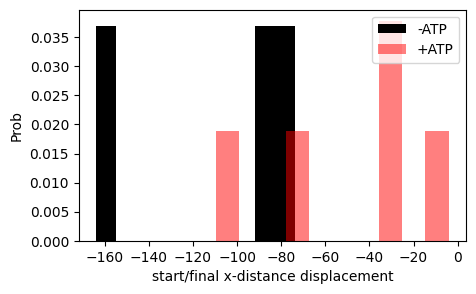

In [ ]:
caseName='-ATP'
case = cases[caseName]
plt.hist(case.dists,density=True,color='black',label='-ATP')

caseName='+ATP'
case = cases[caseName]
plt.hist(case.dists,alpha=0.5,density=True,color='red',label='+ATP')
plt.legend(loc=0)
plt.xlabel("start/final x-distance displacement")
plt.ylabel("Prob")


* Tests
```
cd tests
```
* Run (kafka)
```
python3 ../brownian_v3.py -yamlFile expt.yaml -run
```
* Process
```
python3 batchProcess.py -single expt # kant for now
```
* upload expt.csv



In [ ]:
sourcePath = "/content/cellmigration/"
simFile = sourcePath+"expt_analysis/expt.csv"
simData = np.loadtxt(simFile)

batchProcess.py    concentration.py	      LICENSE		     README_1.md
brownian_v2.py	   conda_openmm_pytraj.ipynb  master.ipynb	     README.md
brownian_v3.py	   config.bash		      migration_paper.ipynb  run
brownian_v4.py	   cont_analysis	      paper		     states.py
brownian_v5.py	   expt_analysis	      parameters.py	     TAM_example.ipynb
brown_util.py	   expt_analysis.ipynb	      pdb.py		     tests
brown_wnonbond.py  histo.ipynb		      processData.py	     update.py
calculator.py	   lattice.py		      processYaml.py	     validation.py


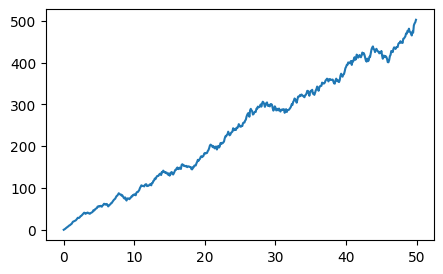

In [ ]:
plt.plot(simData[:,0],simData[:,1])

<font color=red>Need to also load sim case where we measure displacements </font>

Not storing D right now until timescale is worked out


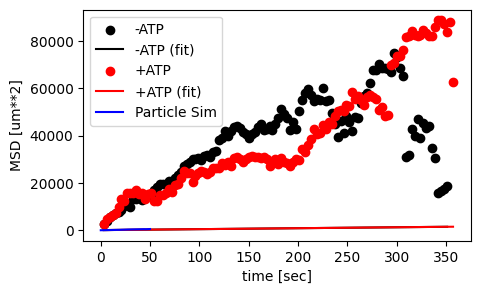

In [ ]:
print("Not storing D right now until timescale is worked out")
sec_to_min = 60.
caseName = '-ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='k',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,'k',label=caseName+" (fit)")

caseName = '+ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='r',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,color='r',label=caseName+" (fit)")

# sims
plt.plot(simData[:,0],simData[:,1],color='b',label="Particle Sim")


plt.xlabel("time [min]")
plt.ylabel("MSD [um**2]")
plt.legend(loc=0)
plt.gcf().savefig("msd.png",dpi=300)

In [ ]:
msd[9]

206.09947014256585